<a href="https://colab.research.google.com/github/patrick013/Image-Classification-CNN-and-VGG/blob/master/Dog_vs_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow-gpu

# **Image Classification Using VGG - Cat or Dog Kaggle Competition**

![catanddog](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)


Ini adalah proyek klasifikasi gambar dari kompetisi [Cat of Dog Kaggel competition](https://www.kaggle.com/c/dogs-vs-cats/overview/description). Dalam proyek ini, saya menerapkan jaringan saraf konvolusional untuk klasifikasi gambar. Dan yang terakhir, saya juga menerapkan jaringan saraf konvolusional VGG-16 dengan menggunakan pembelajaran transfer. VGG-16 adalah jaringan saraf pembelajaran mendalam yang populer dalam visi komputer, diusulkan oleh K. Simonyan dan A. Zisserman dari Universitas Oxford dalam makalah “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)”. Struktur jaringan VGG 16 adalah sebagai berikut:
![VGG](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
import pandas as pd #digunakan untuk mengimpor pustaka atau modul Pandas ke dalam program.
import IPython.display as display #digunakan untuk mengimpor modul display dari pustaka IPython.
import tensorflow as tf #sintaks Python yang mengimpor pustaka TensorFlow dengan menggunakan alias "tf".
from tensorflow.keras import layers #pernyataan yang digunakan untuk mengimpor modul tertentu dari TensorFlow yg berfokus pada pengembangan model neural network.
import numpy as np #digunakan untuk mengimpor modul NumPy ke dalam program. NumPy adlh modul yg sangat berguna untuk melakukan operasi numerik dan manipulasi array.
import os,random #Mendapatkan daftar file dalam suatu direktorid dan Menghasilkan bilangan acak antara 1 dan 10
import matplotlib.pyplot as plt #digunakan untuk membuat visualisasi data dalam bentuk grafik, plot, dan diagram.
print(tf.__version__) #untuk mencetak (menampilkan) versi TensorFlow yang sedang digunakan pada lingkungan Python tersebut.

2.14.0


## **Prepare Data**

Kumpulan data telah dibagi menjadi dua bagian - kumpulan pelatihan yang berisi 25.000 gambar dag dan kucing. Dalam proyek ini, model dilatih pada set pelatihan dan diuji pada set pengujian yang mencakup 12.500 gambar. Karena mengunggah kumpulan data ke google colab memakan waktu. [Yura Istomin](https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9) memberi saya ide untuk mengunggah kumpulan data ke github dan mengkloning repositori, yang berfungsi sempurna untuk menggunakan kumpulan data di Google colab.

In [ ]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

Cloning into 'Image-Classification-CNN-and-VGG'...
remote: Enumerating objects: 37510, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 37510 (delta 43), reused 36 (delta 7), pack-reused 37414
Receiving objects: 100% (37510/37510), 812.51 MiB | 15.86 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (50016/50016), done.


In [ ]:
IMAGE_HEIGHT=128 #Variabel ini menyimpan nilai tinggi (height) gambar, yaitu 128 piksel.
IMAGE_WIDTH=128 #Variabel ini menyimpan nilai lebar (width) gambar, yaitu 128 piksel.
BATCH_SIZE=64 #Variabel ini menyimpan nilai ukuran batch yang akan digunakan dalam proses pelatihan model, yaitu 64.
def get_pathframe(path): #Ini adalah deklarasi fungsi bernama get_pathframe yang menerima satu parameter path.
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path) # Menggunakan modul os, fungsi ini mengambil daftar nama file dalam direktori yang diberikan oleh parameter path.
  categories = [] # Membuat dua list kosong yang akan digunakan untuk menyimpan kategori dan path gambar.
  paths=[]
  for filename in filenames: # Melakukan iterasi melalui setiap nama file dalam direktori.
    paths.append(path+filename) # Menyimpan path lengkap dari setiap file gambar.
    category = filename.split('.')[0] # Membuat kategori dengan mengambil bagian dari nama file sebelum tanda titik (.) dalam ekstensi file.
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)
      # Jika kategori adalah 'dog', maka nilai kategori ditetapkan sebagai 1, dan jika bukan, maka ditetapkan sebagai 0.

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  }) # Membuat pandas DataFrame menggunakan informasi yang telah dikumpulkan sebelumnya, yaitu nama file, kategori, dan path.
  return df # Mengembalikan DataFrame yang berisi informasi tentang gambar-gambar di direktori yang diberikan oleh parameter path.

In [ ]:
df=get_pathframe("Image-Classification-CNN-and-VGG/dataset/dataset/")
df.tail(5) #  kode tersebut mengambil lima baris terakhir dari suatu DataFrame yang berisi path (jalur) file dari dataset yang terletak di direktori

,filename,category,paths
24995,cat.1325.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24996,cat.11004.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24997,cat.2951.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24998,cat.7867.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24999,cat.11805.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...


In [ ]:
def load_and_preprocess_image(path): # Fungsi ini digunakan untuk memuat dan memproses gambar dari suatu path (alamat file).
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path) # Membaca file gambar.
  image = tf.image.decode_jpeg(image, channels=3) # Mendecode gambar menggunakan format JPEG dengan 3 saluran warna (RGB).
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT]) # Mengubah ukuran gambar menjadi lebar dan tinggi yang diinginkan (diasumsikan bahwa IMAGE_WIDTH dan IMAGE_HEIGHT adalah variabel yang telah didefinisikan sebelumnya).
  image /= 255.0  # Normalisasi nilai pixel gambar ke rentang [0, 1].
  return image

def convert_to_tensor(df): # Fungsi ini digunakan untuk mengonversi data dan label dari suatu DataFrame ke dalam bentuk tensor.
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths']) # Membuat dataset dari path gambar yang terdapat dalam kolom 'paths' dari DataFrame.
  image_ds = path_ds.map(load_and_preprocess_image) # Memetakan fungsi load_and_preprocess_image pada setiap path gambar dalam dataset.
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64) # Mengonversi kolom 'category' dari DataFrame ke dalam tipe data int64. Ini diasumsikan sebagai label kategori (variabel kategorikal).
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label) # Membuat dataset dari label yang telah dihasilkan.

  return image_ds,label_ds

In [ ]:
X,Y=convert_to_tensor(df) # metode bernama convert_to_tensor yang dipanggil, menerima objek DataFrame df, dan mengembalikan dua nilai, yaitu X dan Y.
print("Shape of X in data:", X) # mencetak bentuk (shape) dari tensor X ke dalam konsol atau output.
print("Shape of Y in data:", Y) # mencetak bentuk (shape) dari tensor Y ke dalam konsol atau output.

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000) # membuat objek dataset menggunakan TensorFlow.
dataset_train=dataset.take(22500) # membuat subset dari dataset untuk digunakan sebagai data latih. Sebanyak 22,500 data diambil dari dataset awal.
dataset_test=dataset.skip(22500) # membuat subset yang berbeda untuk digunakan sebagai data uji. Sebanyak 22,500 data diabaikan (dilewati) dari dataset awal dan digunakan sebagai data uji.

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True) # menandakan bahwa jika ada sisa data yang tidak cukup untuk membentuk satu batch, data tersebut akan diabaikan.
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True) # melakukan hal yang sama untuk data uji seperti yang dijelaskan pada langkah sebelumnya.
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

### **Check Images**

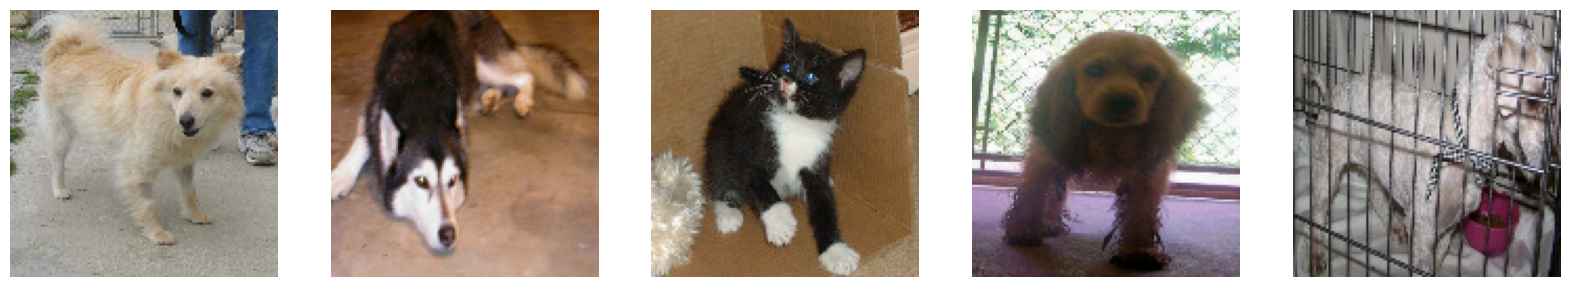

In [ ]:
def plotimages(imagesls): # Menerima satu parameter, yaitu imagesls, yang merupakan list dari gambar-gambar yang akan diplot.
  fig, axes = plt.subplots(1, 5, figsize=(20,20)) # Ukuran keseluruhan gambar (figure) adalah 20x20 inci.
  axes = axes.flatten() # Flatten array dari subplot agar mudah diakses menggunakan
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[] # Membuat list kosong imagesls yang nantinya akan diisi dengan lima gambar.
for n, image in enumerate(X.take(5)): # Menggunakan loop for dan fungsi enumerate untuk mengambil lima gambar pertama dari data X (mungkin berupa dataset gambar).
  imagesls.append(image) # Menambahkan setiap gambar ke dalam list imagesls.

plotimages(imagesls) #  fungsi plotimages dipanggil untuk menampilkan gambar-gambar tersebut dalam satu tampilan subplot.

## **Convolutional Neural Networks**
### Build Network

Arsitektur CNN yang digunakan dalam proyek ini ditunjukkan sebagai berikut (PS: jaringan yang terhubung sepenuhnya tidak ditampilkan pada gambar):

![mynetwork](https://raw.githubusercontent.com/patrick013/Image-Classification-CNN-and-VGG/master/pictures/mycnnmodel.png)

In [ ]:
def My_CNNmodel(): # Membuat model neural network berbasis urutan (sequential), di mana layer-layer ditambahkan satu per satu secara berurutan.

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # Convolutional Layers Menambahkan layer-layer konvolusi dengan jumlah filter (8, 16, 32, 64 masing-masing) dan ukuran kernel (3x3). Fungsi aktivasi yang digunakan adalah ReLU.
  # MaxPooling Layers Menambahkan layer max pooling untuk mengurangi resolusi spasial.
  # Flatten Layer Meratakan output dari layer-layer sebelumnya menjadi vektor satu dimensi.
  # Dense Layers Menambahkan layer-layer dense (fully connected) dengan 512 neuron dan fungsi aktivasi ReLU, serta layer output dengan satu neuron dan fungsi aktivasi sigmoid (karena ini adalah tugas klasifikasi biner).



  opt=tf.keras.optimizers.Adam(0.001) # Mengkompilasi model dengan pengoptimal Adam, fungsi loss binary_crossentropy (karena ini adalah klasifikasi biner), dan metrik akurasi untuk evaluasi performa model.
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
model=My_CNNmodel() # Membuat objek model CNN dengan menggunakan fungsi atau kelas
model.summary() # Menampilkan ringkasan dari struktur model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

### **Training**

Training adalah langkah di mana model mesin (algoritma) belajar dari data yang diberikan untuk melakukan tugas tertentu tanpa secara eksplisit diprogram. Proses ini melibatkan penyediaan model dengan sejumlah besar data yang sesuai, dan model secara otomatis menyesuaikan parameter atau bobotnya untuk membuat prediksi atau pengklasifikasian yang lebih baik.

In [ ]:
hist=model.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)
model.save("/content/drive/My Drive/DPprojects/DogvsCats/my_model")

Epoch 1/20


<ipython-input-11-050cced401f6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)


351/351 [==============================] - 59s 125ms/step - loss: 0.5771 - accuracy: 0.6850 - val_loss: 0.5213 - val_accuracy: 0.7416
Epoch 2/20
351/351 [==============================] - 49s 135ms/step - loss: 0.4619 - accuracy: 0.7808 - val_loss: 0.4060 - val_accuracy: 0.8273
Epoch 3/20
351/351 [==============================] - 45s 125ms/step - loss: 0.4001 - accuracy: 0.8182 - val_loss: 0.3898 - val_accuracy: 0.8241
Epoch 4/20
351/351 [==============================] - 47s 129ms/step - loss: 0.3690 - accuracy: 0.8340 - val_loss: 0.3541 - val_accuracy: 0.8438
Epoch 5/20
351/351 [==============================] - 66s 184ms/step - loss: 0.3357 - accuracy: 0.8500 - val_loss: 0.3286 - val_accuracy: 0.8562
Epoch 6/20
351/351 [==============================] - 52s 146ms/step - loss: 0.2970 - accuracy: 0.8724 - val_loss: 0.2987 - val_accuracy: 0.8750
Epoch 7/20
351/351 [==============================] - 47s 130ms/step - loss: 0.2638 - accuracy: 0.8864 - val_loss: 0.3007 - val_accuracy: 0.8

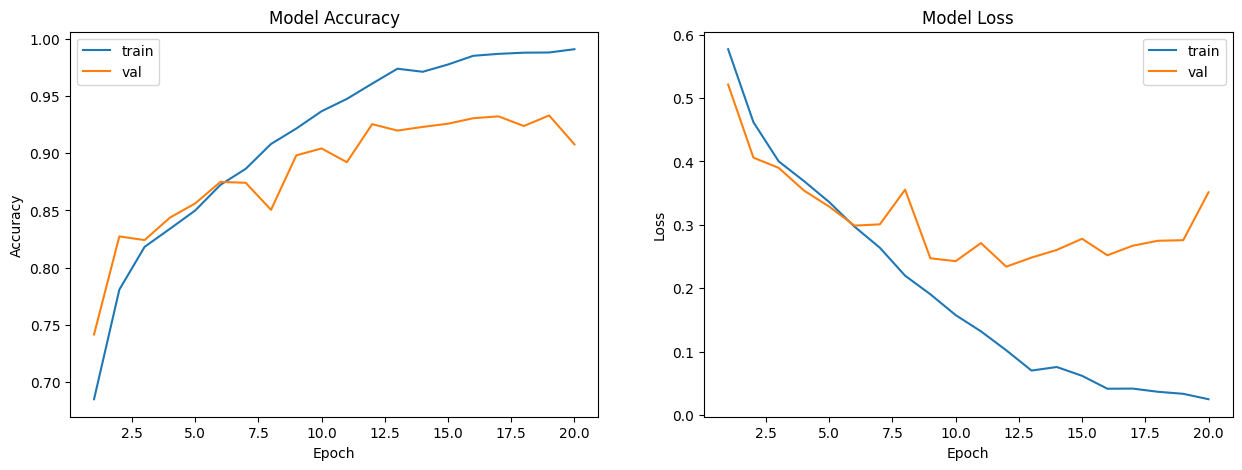

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5)) # Membuat satu baris dan dua kolom subplot dengan ukuran total gambar 15x5.
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc]) # Plot garis untuk akurasi pelatihan dan validasi pada subplot pertama.
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy') # Judul subplot pertama diatur sebagai 'Model Accuracy'.
    axs[0].set_ylabel('Accuracy') # Label sumbu-y diatur sebagai 'Accuracy'.
    axs[0].set_xlabel('Epoch') # Label sumbu-x diatur sebagai 'Epoch'.
    axs[0].legend(['train', 'val'], loc='best') # Menambahkan legenda untuk setiap garis, yaitu 'train' untuk data pelatihan dan 'val' untuk data validasi.
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss']) # Plot garis untuk loss pelatihan dan validasi pada subplot kedua.
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss') # Judul subplot kedua diatur sebagai 'Model Loss'.
    axs[1].set_ylabel('Loss') # Label sumbu-y diatur sebagai 'Loss'.
    axs[1].set_xlabel('Epoch') # Label sumbu-x diatur sebagai 'Epoch'.
    axs[1].legend(['train', 'val'], loc='best') # Menambahkan legenda untuk setiap garis, yaitu 'train' untuk data pelatihan dan 'val' untuk data validasi.
    plt.show() # Menampilkan gambar yang berisi kedua subplot.

plot_model_history(hist) # fungsi plot_model_history dipanggil dengan memberikan parameter hist sebagai argumen.

### Overfitting

Obviously, my model is overfitted! To overcome the problem of overfitting, there are some ways to do:
1. Expand dataset
2. Use regularization
3. Add dropout layers


```
tf.keras.layers.Dropout(0.5)
```
4. Use batchnormalization


```
tf.keras.layers.BatchNormalization()
```



### **Evaluation**

<ipython-input-13-de1587aefbb2>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(dataset_test)


Test: accuracy = 0.912260  ;  loss = 0.346995 


<ipython-input-13-de1587aefbb2>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred =  model.predict_generator(dataset_test)


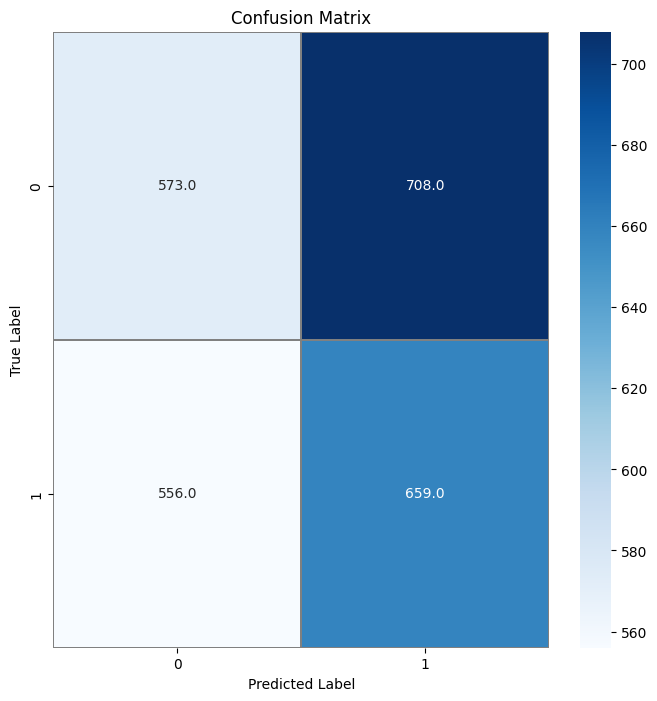

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predict the values from the validation dataset


loss, accuracy = model.evaluate_generator(dataset_test) # Model dievaluasi menggunakan generator (evaluate_generator) pada dataset uji (dataset_test).
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss)) # Model dievaluasi dengan menggunakan generator (evaluate_generator) pada dataset uji (dataset_test). Hasil evaluasi, yaitu nilai loss dan akurasi, kemudian dicetak.y_pred =  model.predict_generator(dataset_test)
y_p = np.where(y_pred > 0.5, 1,0) # Model melakukan prediksi pada dataset uji menggunakan generator (predict_generator). Hasil prediksi kemudian diubah menjadi kelas biner (0 atau 1) menggunakan ambang batas 0,5 (np.where(y_pred > 0.5, 1, 0)).
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Dengan menggunakan confusion matrix,
# kita dapat mendapatkan informasi lebih rinci tentang seberapa baik model dapat melakukan klasifikasi pada dataset uji,
# termasuk detil tentang true positive, true negative, false positive, dan false negative.
# Heatmap juga memberikan representasi visual yang memudahkan untuk memahami pola hasil klasifikasi.

In [ ]:
# Generate a classification report
report = classification_report(y_g, y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1262
           1       0.47      0.44      0.45      1234

    accuracy                           0.48      2496
   macro avg       0.48      0.48      0.48      2496
weighted avg       0.48      0.48      0.48      2496



classification_report(y_g, y_p, target_names=['0','1']): Kode ini menghasilkan laporan klasifikasi berdasarkan perbandingan antara nilai sebenarnya (y_g atau "ground truth") dan nilai yang diprediksi (y_p atau "predicted"). Parameter target_names digunakan untuk memberikan label kelas yang sesuai dengan dataset, dalam hal ini '0' dan '1'.

print(report): Kode ini mencetak laporan klasifikasi ke konsol atau output. Laporan klasifikasi ini berisi informasi yang sangat berguna untuk mengevaluasi kinerja model klasifikasi, termasuk precision, recall, f1-score, dan support untuk setiap kelas yang ada.

### **Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### **Horizontal Flip**

Found 21000 images belonging to 2 classes.


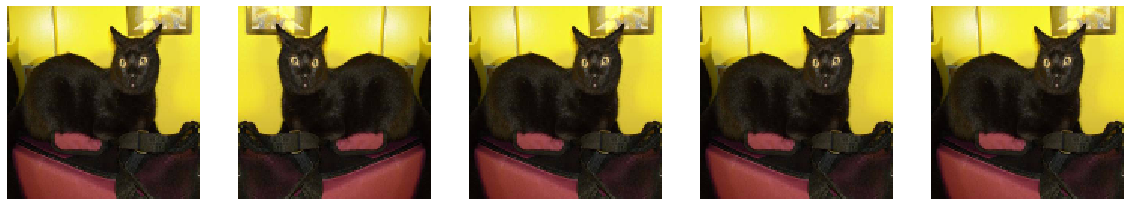

In [ ]:
image_gen_flip = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen_flip.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

codingan tersebut digunakan untuk mempersiapkan data pelatihan yang sudah di-augmentasi dengan horizontal flip untuk penggunaan selanjutnya dalam melatih model jaringan saraf tiruan pada tugas klasifikasi gambar.

#### **Rotation**

Found 21000 images belonging to 2 classes.


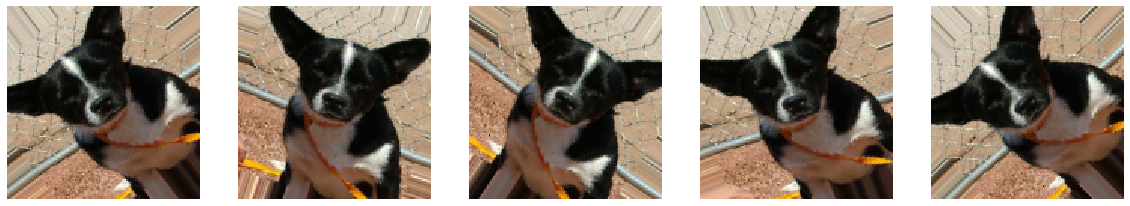

In [ ]:
image_gen_rotate = ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen_rotate.flow_from_directory(batch_size=BATCH_SIZE,
                                                       directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                       shuffle=True,
                                                       target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

codingan tersebut adalah menggunakan ImageDataGenerator untuk menghasilkan gambar-gambar yang telah dirotasi secara acak, dan kemudian mengekstrak beberapa gambar hasil augmentasi untuk tujuan visualisasi atau mungkin evaluasi model.

#### **Zoom Augmentation**

Found 21000 images belonging to 2 classes.


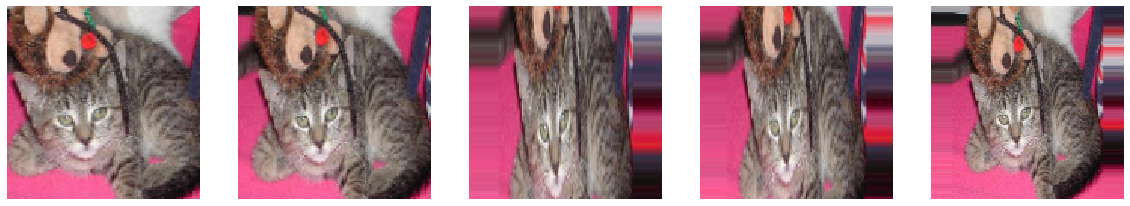

In [ ]:
image_gen_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen_zoom.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                    shuffle=True,
                                                    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotimages(augmented_images)

Dengan menggunakan augmentasi data seperti ini, model pembelajaran mesin dapat melihat variasi yang lebih besar dalam data pelatihan, membantu mencegah overfitting, dan meningkatkan kinerja model pada data yang belum pernah dilihat sebelumnya.

#### **Pull Together**

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Image-Classification-CNN-and-VGG/dataset/train_validation/train",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
validation_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory="Image-Classification-CNN-and-VGG/dataset/train_validation/validation",
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


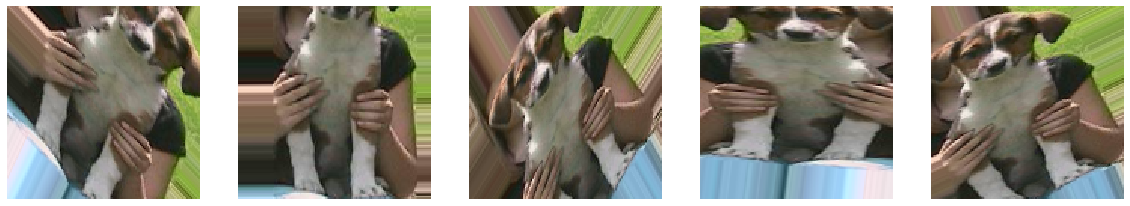

In [ ]:
plotimages([train_data_gen[0][0][0] for i in range(5)])

Dengan menggunakan ImageDataGenerator, kita dapat memperluas variasi dataset pelatihan dan meningkatkan kinerja model jaringan saraf tiruan pada tugas pengenalan gambar atau klasifikasi.

###**Retrain**

In [ ]:
def Mynew_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

Fungsi Mynew_CNNmodel adalah untuk membuat dan mengembalikan model neural network yang menggunakan arsitektur Convolutional Neural Network (CNN) untuk tugas klasifikasi biner. Fungsi ini membuat dan mengonfigurasi model CNN untuk tugas klasifikasi biner dengan menggunakan TensorFlow dan Keras. Model ini cocok untuk aplikasi pengenalan gambar atau klasifikasi biner berdasarkan dataset yang sesuai.

In [ ]:
new_model=Mynew_CNNmodel()
new_hist=new_model.fit_generator(train_data_gen,epochs=20,validation_data=validation_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 329 steps, validate for 63 steps
Epoch 1/20
329/329 [==============================] - 166s 506ms/step - loss: 0.7811 - accuracy: 0.6255 - val_loss: 3.1312 - val_accuracy: 0.5027
Epoch 2/20
329/329 [==============================] - 168s 510ms/step - loss: 0.5953 - accuracy: 0.6743 - val_loss: 0.6002 - val_accuracy: 0.6500
Epoch 3/20
329/329 [==============================] - 167s 509ms/step - loss: 0.5799 - accuracy: 0.6881 - val_loss: 0.6275 - val_accuracy: 0.6802
Epoch 4/20
329/329 [==============================] - 168s 510ms/step - loss: 0.5633 - accuracy: 0.7047 - val_loss: 0.5783 - val_accuracy: 0.7063
Epoch 5/20
329/329 [==============================] - 168s 512ms/step - loss: 0.5469 - accuracy: 0.7169 - val_loss: 0.5686 - val_accuracy: 0.6942
Epoch 6/20
329/329 [==============================] - 168s 511ms/step - loss: 0.5336 - accuracy: 0.7259 - val_loss: 0.5235 - val_accuracy: 0.7322
Epoch 7/20
329/329 [===========

Dengan menggunakan metode fit_generator(), model akan disesuaikan dengan data latih dan dievaluasi terhadap data validasi selama proses pelatihan. Proses ini memungkinkan model belajar untuk menyesuaikan diri dengan pola-pola yang ada dalam data dan meminimalkan kerugian (loss) seiring berjalannya waktu.

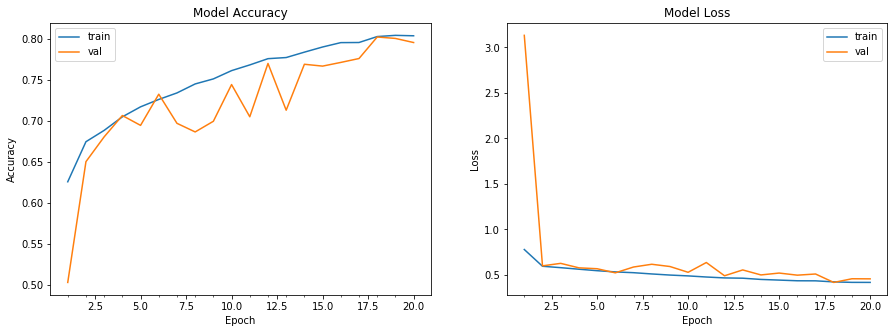

In [ ]:
plot_model_history(new_hist)

merupakan panggilan fungsi untuk membuat plot visualisasi dari riwayat pelatihan model menggunakan suatu fungsi bernama plot_model_history. Di dalam tanda kurung (new_hist) terdapat argumen atau parameter yang diberikan kepada fungsi tersebut.

## **Transfer Learning - VGG16**

The output of dataset should be changed!

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

Codingan di atas menggunakan TensorFlow dan Keras untuk membuat dan mengonfigurasi model jaringan saraf konvolusional (CNN) menggunakan arsitektur VGG16 untuk tugas klasifikasi biner (binary classification). Codingan ini adalah menggunakan model arsitektur VGG16 yang telah dilatih sebelumnya, menyesuaikannya untuk tugas klasifikasi biner dengan menambahkan lapisan-lapisan tambahan, dan mengompilasi model untuk melatihnya pada data spesifik dengan kriteria tertentu.

### **Training**

In [ ]:
vgghist=vggmodel.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)


Train for 351 steps, validate for 39 steps
Epoch 1/20
351/351 [==============================] - 123s 350ms/step - loss: 0.4689 - accuracy: 0.7671 - val_loss: 0.2975 - val_accuracy: 0.8710
Epoch 2/20
351/351 [==============================] - 120s 342ms/step - loss: 0.2836 - accuracy: 0.8783 - val_loss: 0.2389 - val_accuracy: 0.8978
Epoch 3/20
351/351 [==============================] - 121s 344ms/step - loss: 0.2395 - accuracy: 0.8999 - val_loss: 0.2172 - val_accuracy: 0.9054
Epoch 4/20
351/351 [==============================] - 121s 344ms/step - loss: 0.2156 - accuracy: 0.9098 - val_loss: 0.1978 - val_accuracy: 0.9191
Epoch 5/20
351/351 [==============================] - 120s 343ms/step - loss: 0.1963 - accuracy: 0.9181 - val_loss: 0.1826 - val_accuracy: 0.9247
Epoch 6/20
351/351 [==============================] - 120s 342ms/step - loss: 0.1842 - accuracy: 0.9245 - val_loss: 0.1691 - val_accuracy: 0.9307
Epoch 7/20
351/351 [==============================] - 120s 342ms/step - loss: 0.1

codingan ini melakukan pelatihan model VGG menggunakan generator data untuk pelatihan (dataset_train) selama 20 epoch. Evaluasi performa model dilakukan pada setiap epoch menggunakan dataset validasi (dataset_test). Proses pelatihan ini akan mengoptimalkan parameter-parameter model (misalnya, bobot dan bias) agar dapat melakukan prediksi yang lebih baik terhadap data yang diberikan.

In [ ]:
vggmodel.save("/content/drive/My Drive/DPprojects/DogvsCats/vggmodel.h5")

Baris kode di atas digunakan untuk menyimpan model VGG (Visual Geometry Group) ke dalam file dengan format H5.

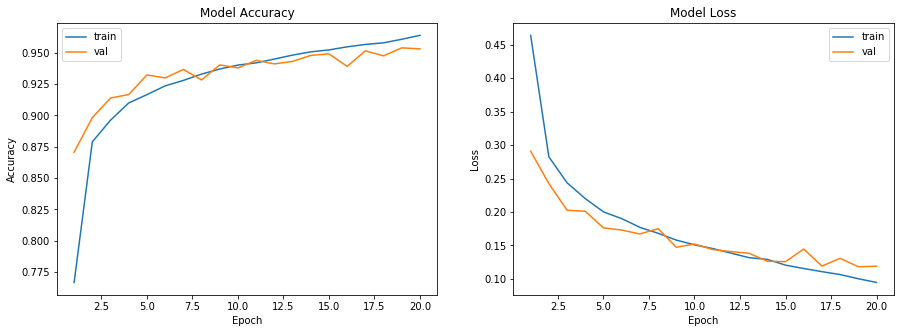

In [ ]:
plot_model_history(vgghist)

### **Evaluation**


In [ ]:
loss, accuracy = vggmodel.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.953125  ;  loss = 0.124623 


In [ ]:
vgg_y_pred =  model.predict_generator(dataset_test)
vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)

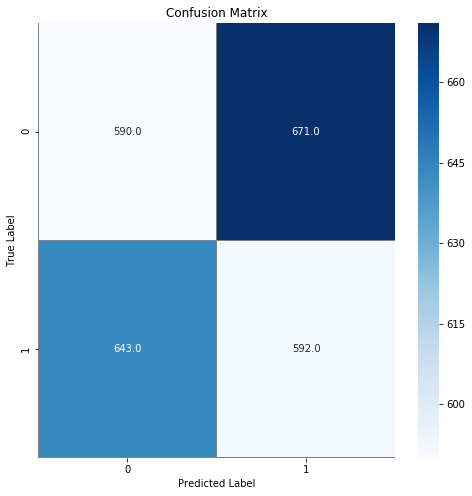

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_g, vgg_y_p)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report = classification_report(y_g, vgg_y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.48      0.47      0.47      1261
           1       0.47      0.48      0.47      1235

    accuracy                           0.47      2496
   macro avg       0.47      0.47      0.47      2496
weighted avg       0.47      0.47      0.47      2496



## **Summary**
Obviously, VGG wins! My model to some degress is overfitted, which means the accuracy on training set is higher than that on validation set. To solve this problem:
1. Batch Normalization
2. Dropout
3. Regularization

### Big Challenge - Loss does not change

The biggest challenge that I met was that there was not a sign that the loss tended to decrease at all after 10 epochs when I was using VGG network. I spent whole night to fix this problem and tried many suggestions online, such as check the dataset labels, reducing the networks and so on. However, it didn't work at all. One of the reason was that I forgot to convert y label to one hot array.